In [1]:
%matplotlib inline
import ipywidgets as widgets
import cv2
import IPython
import time
from io import BytesIO      
import numpy as np
import PIL
from IPython.display import display
import copy
import os

In [2]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()

    #flip image for natural viewing
    frame = cv2.flip(frame, 1)
    
    #frame = modify_frame(frame)

    return frame

def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()

    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)

    return IPython.display.Image(data=f.getvalue())

def process_image(frame):
    kernel = np.ones((3, 3), np.uint8)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of skin color in HSV
    lower_skin = np.array([0, 36, 0], dtype=np.uint8)
    upper_skin = np.array([57, 158, 255], dtype=np.uint8)
    # extract skin colur image
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    # extrapolate the hand to fill dark spots within
    frame = cv2.dilate(mask, kernel, iterations=4)
    # blur the image
    return frame

def segment_hand_from_image(frame):
    blurValue = 41  # GaussianBlur parameter
    frame = cv2.bilateralFilter(frame, 5, 50, 100)
    frame = cv2.flip(frame, 1)
    img = frame
    img = cv2.GaussianBlur(img, (blurValue, blurValue), 0)
    img_copy = copy.deepcopy(img)
    img = process_image(img)
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if len(contours) != 0:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = img_copy[y: y + h, x: x + w]
        roi = process_image(roi)
    return roi

In [46]:
path_to_images = "images/"
gestures = ['high_five', 'null']

In [47]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [48]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

# data for generation

In [53]:
dir_open_hand = path_to_images+gestures[1]
image_list = [itr for itr in os.listdir(dir_open_hand) if itr[0]!="."]
image_size = (224, 224)

In [54]:
X = []
for image_name in image_list:
    img = cv2.imread(dir_open_hand+"/"+image_name)
    img = cv2.resize(img, image_size)
    if 'image_shape' in globals():
        pass
    else:
        image_shape = img.shape
    X.append(img)

In [55]:
X = np.array(X)

In [56]:
count = 0
for batch in datagen.flow(X, batch_size=2,save_to_dir=dir_open_hand, save_prefix='generated', save_format='jpeg'):
    count += 1
    if count > 100:
        break

# Load entire data

In [57]:
path_to_images = "images/"
gestures = {'high_five':1, 'null':0}

In [58]:
X = []
y = []
for gesture in gestures.keys():
    path_ = path_to_images + gesture + "/"
    for image_path in os.listdir(path_):
        if image_path[0] == ".":
            continue
        y.append(gestures[gesture])
        img = cv2.imread(path_+image_path)
        try:
            img = img.resize(img, image_size)
        except:
            pass
        X.append(img)
        """
        if "generated" in image_path:
            os.remove(path_+image_path)
        """

In [59]:
for itr in range(len(X)):
    if X[itr].shape[1:3] != (224, 224, 3):
        X[itr] = cv2.resize(X[itr], image_size)

In [60]:
from keras.utils import to_categorical
X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=2, dtype='float32')

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MobileNet V2

In [82]:
from keras import applications
mdl = applications.mobilenet_v2.MobileNetV2(input_shape=X.shape[1:], include_top=False, weights='imagenet')

In [83]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, MaxPool1D, MaxPooling2D, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape=X.shape[1:]
model = Sequential()
model.add(mdl)
model.add(MaxPooling2D(pool_size=(5, 5), strides=5, padding='valid', data_format=None))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [84]:
model.fit(X_train, y_train, batch_size = 20, epochs=5)

Epoch 1/5
527/527 [==============================] - 73s 138ms/step - loss: 1.2234 - accuracy: 0.5294
Epoch 2/5
527/527 [==============================] - 81s 153ms/step - loss: 0.8278 - accuracy: 0.6945
Epoch 3/5
527/527 [==============================] - 84s 159ms/step - loss: 0.5584 - accuracy: 0.7970
Epoch 4/5
527/527 [==============================] - 81s 153ms/step - loss: 0.4322 - accuracy: 0.8539
Epoch 5/5
527/527 [==============================] - 78s 149ms/step - loss: 0.3494 - accuracy: 0.8994


In [85]:
y_prediction = model.predict_classes(X_test)

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
def get_classification_report(y_test, y_predict):
    """
    Gives out classification report for predictions of a model
    """
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_predict))
    print("\n\nClassification Report")
    print(classification_report(y_test, y_predict))


In [89]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_prediction)

array([[[91,  0],
        [ 0, 41]],

       [[76,  5],
        [11, 40]],

       [[81, 11],
        [ 5, 35]]])

In [91]:
cap_region_x_begin = 0.5  # start point/total width
cap_region_y_end = 0.8  # start point/total width
cam = cv2.VideoCapture(0)
video_width = cam.get(3)
video_height = cam.get(4)
d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
gestures = {'open_hand':1, 'closed_fist':2, 'null':0}
inv_gestures = {1:'open_hand', 2:'close_fist', 0:'null'}
while True:
    try:
        t1 = time.time()
        frame = get_frame(cam)
        roi = segment_hand_from_image(frame)
        cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0), (frame.shape[1], int(cap_region_y_end * frame.shape[0])), (0, 255, 0), 2)
        roi = cv2.resize(roi, image_size)
        roi = np.expand_dims(roi, axis=0)
        roi_copy = copy.deepcopy(roi)
        roi = np.stack((roi, roi_copy, roi_copy), axis=3)
        prediction = model.predict_classes(roi)[0]
        prediction = inv_gestures[prediction]
        
        im = array_to_image(frame)
        

        d.update(im)

        t2 = time.time()

        s = f"""{int(1/(t2-t1))} FPS and prediction is {prediction}"""
        d2.update( IPython.display.HTML(s) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped


# Storing train and test variables as pickle files to run in aws

In [65]:
import pickle
pack_variables = {'X': X, 'y': y}
pickle.dump( pack_variables, open( "variables.pickle", "wb" ) )

# MobileNetV2 exp-2

In [97]:
from keras import applications
mdl = applications.mobilenet_v2.MobileNetV2(input_shape=X.shape[1:], include_top=False, weights='imagenet')

In [98]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, MaxPool1D, MaxPooling2D, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape=X.shape[1:]
model = Sequential()
model.add(mdl)
model.add(MaxPooling2D(pool_size=(5, 5), strides=5, padding='valid', data_format=None))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [100]:
model.fit(X_train, y_train, batch_size = 20, epochs=20)

Epoch 1/20
527/527 [==============================] - 72s 137ms/step - loss: 1.5498 - accuracy: 0.3776
Epoch 2/20
527/527 [==============================] - 61s 117ms/step - loss: 1.0383 - accuracy: 0.4744
Epoch 3/20
527/527 [==============================] - 62s 118ms/step - loss: 0.9767 - accuracy: 0.5617
Epoch 4/20
160/527 [========>.....................] - ETA: 43s - loss: 0.9195 - accuracy: 0.6500

KeyboardInterrupt: 

In [113]:
y_prediction = loaded_model.predict_classes(X_test)

In [111]:
y_prediction = to_categorical(y_prediction, num_classes=3, dtype='float32')

In [112]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_prediction)

array([[[91,  0],
        [ 0, 41]],

       [[81,  0],
        [ 1, 50]],

       [[91,  1],
        [ 0, 40]]])

In [129]:
cap_region_x_begin = 0.5  # start point/total width
cap_region_y_end = 0.8  # start point/total width
cam = cv2.VideoCapture(0)
video_width = cam.get(3)
video_height = cam.get(4)
d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
gestures = {'open_hand':1, 'closed_fist':2, 'null':0}
inv_gestures = {1:'open_hand', 2:'close_fist', 0:'null'}
while True:
    try:
        t1 = time.time()
        frame = get_frame(cam)
        roi = segment_hand_from_image(frame)
        cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0), (frame.shape[1], int(cap_region_y_end * frame.shape[0])), (0, 255, 0), 2)
        roi = cv2.resize(roi, image_size)
        roi = np.expand_dims(roi, axis=0)
        roi_copy = copy.deepcopy(roi)
        
        roi = np.stack((roi, roi_copy, roi_copy), axis=3)
        prediction = loaded_model.predict_classes(roi)[0]
        prediction = inv_gestures[prediction]
        
        im = array_to_image(roi.reshape(roi.shape[1:]))
        

        d.update(im)

        t2 = time.time()

        s = f"""{int(1/(t2-t1))} FPS and prediction is {prediction}"""
        d2.update( IPython.display.HTML(s) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped


In [105]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


open_hand


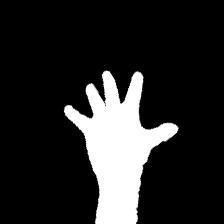

In [125]:
print(inv_gestures[y_prediction[2]])
array_to_image(X_test[2])

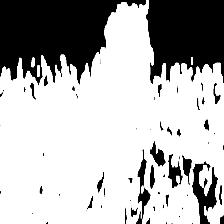

In [128]:
array_to_image(roi.reshape(roi.shape[1:]))

In [41]:
X.shape

(1459, 224, 224, 3)